# Circuit cutting for depth reduction
*Usage estimate: 8 minutes on IBM Brisbane (NOTE: This is an estimate only. Your runtime may vary.)*

## Background

In this tutorial, we will show how to build a `Qiskit Pattern` for cutting gates in a quantum circuit to reduce circuit depth. For more in-depth discussion on circuit cutting, visit the [circuit cutting Qiskit addon docs](https://qiskit.github.io/qiskit-addon-cutting/).

## Requirements

Before starting this tutorial, be sure you have the following installed:
- Qiskit SDK v1.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
- Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)
- Circuit cutting Qiskit addon 0.9.0 or later (`pip install qiskit-addon-cutting`)

## Setup

In [1]:
import numpy as np

from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import PauliList, Statevector, SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_addon_cutting import (
    cut_gates,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

## Step 1: Map classical inputs to a quantum problem

We will implement our Qiskit Pattern using the four steps outlined in the [docs](/docs/guides/intro-to-patterns). In this case, we will simulate expectation values on a circuit of a certain depth by cutting gates resulting in swap gates and executing subexperiments on shallower circuits. Gate cutting is relevant for Steps 2 (optimize circuit for quantum execution by decomposing distant gates) and 4 (post-processing to reconstruct expectation values on original circuit).
In the first step, we'll generate a circuit from the Qiskit circuit library and define some observables.

*   Input: Classical parameters to define a circuit
*   Output: Abstract circuit and observables

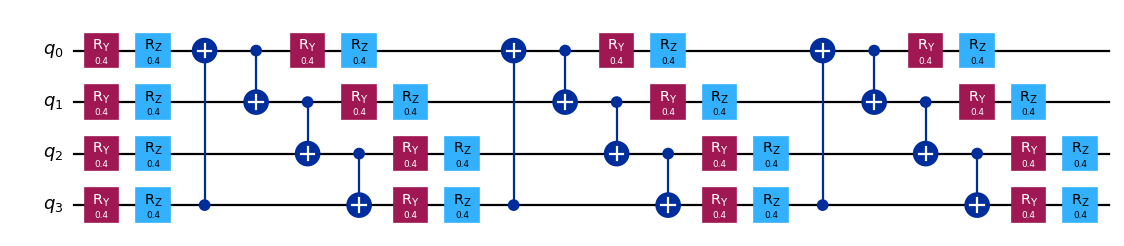

In [2]:
circuit = EfficientSU2(num_qubits=4, entanglement="circular").decompose()
circuit.assign_parameters([0.4] * len(circuit.parameters), inplace=True)
observables = PauliList(["ZZII", "IZZI", "IIZZ", "XIXI", "ZIZZ", "IXIX"])
circuit.draw("mpl", scale=0.8, style="iqp")

## Step 2: Optimize problem for quantum hardware execution

*   Input: Abstract circuit and observables
*   Output: Target circuit and observables produced by cutting distant gates to reduce transpiled circuit depth

We choose an initial layout that requires two swaps to execute the gates between qubits 3 and 0 and another two swaps to return the qubits to their initial positions. We choose `optimization_level=3`, which is the highest level of optimization available with a preset pass manager.

In [ ]:
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, min_num_qubits=circuit.num_qubits, simulator=False
)

pm = generate_preset_pass_manager(
    optimization_level=3, initial_layout=[0, 1, 2, 3], backend=backend
)
transpiled_qc = pm.run(circuit)

![swaps-2.png](https://learning-api.quantum.ibm.com/assets/ce74853a-8e5b-460b-9dc6-69eeadca2d05)

Transpiled circuit depth: 103


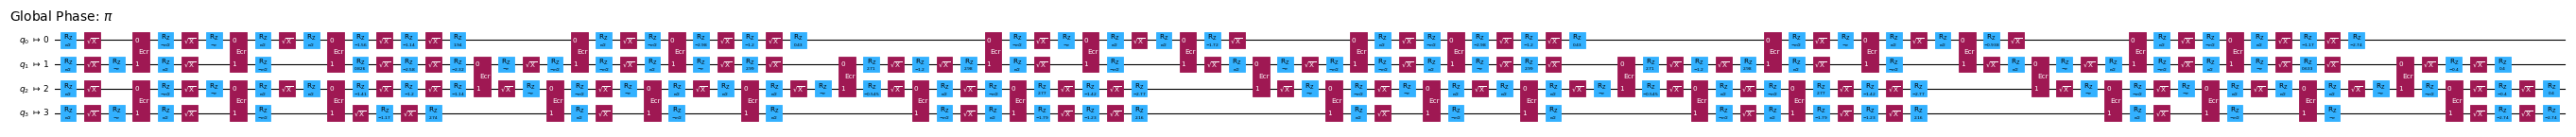

In [4]:
print(f"Transpiled circuit depth: {transpiled_qc.depth()}")
transpiled_qc.draw("mpl", scale=0.4, idle_wires=False, style="iqp", fold=-1)

*Find and cut the distant gates:* We will replace the distant gates (gates connecting non-local qubits, 0 and 3) with `TwoQubitQPDGate`s by specifying their indices. `cut_gates` will replace the gates in the specified indices with `TwoQubitQPDGate`s and also return a list of `QPDBasis` instances -- one for each gate decomposition. The `QPDBasis` object contains information about how to decompose the cut gates into single-qubit operations.

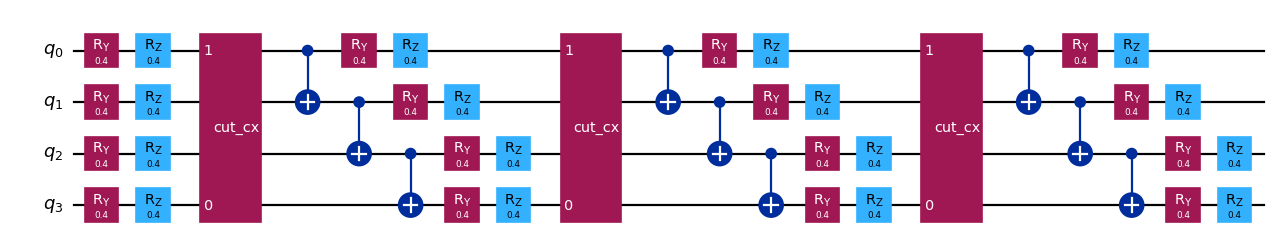

In [5]:
# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(circuit.data)
    if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0, 3}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(circuit, cut_indices)

qpd_circuit.draw("mpl", scale=0.8)

*Generate the subexperiments to run on the backend*: `generate_cutting_experiments` accepts a circuit containing `TwoQubitQPDGate` instances and observables as a `PauliList`.

To simulate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more backends. The number of samples taken from the distribution is controlled by `num_samples`, and one combined coefficient is given for each unique sample. For more information on how the coefficients are calculated, refer to the [explanatory material](https://qiskit.github.io/qiskit-addon-cutting/explanation/index.html).

In [6]:
# Generate the subexperiments and sampling coefficients
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observables, num_samples=np.inf
)

*For comparison, we see that the QPD subexperiments will be shallower after cutting distant gates*: Here is an example of an arbitrarily chosen subexperiment generated from the QPD circuit. Its depth has been reduced by more than half. Many of these probabilistic subexperiments must be generated and evaluated in order to reconstruct an expectation value of the deeper circuit.

Original circuit depth after transpile: 103
QPD subexperiment depth after transpile: 46


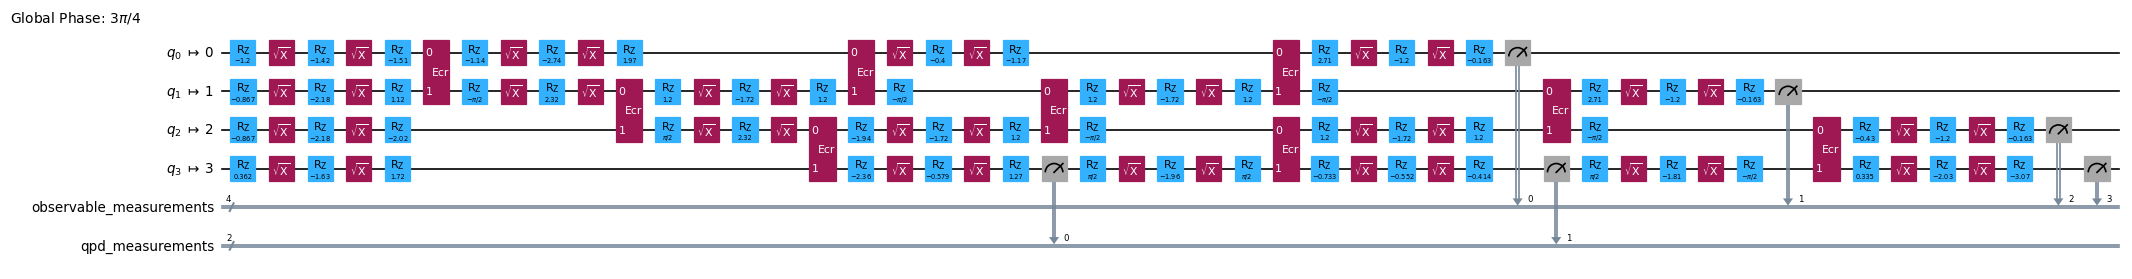

In [7]:
# Transpile the decomposed circuit to the same layout
transpiled_qpd_circuit = pm.run(subexperiments[100])

print(f"Original circuit depth after transpile: {transpiled_qc.depth()}")
print(
    f"QPD subexperiment depth after transpile: {transpiled_qpd_circuit.depth()}"
)
transpiled_qpd_circuit.draw(
    "mpl", scale=0.6, style="iqp", idle_wires=False, fold=-1
)

*On the other hand, cutting results in the need of extra sampling*. Here we cut three CNOT gates, resulting in a sampling overhead of $9^3$. For more on the sampling overhead incurred by circuit cutting, refer to the [Circuit Knitting Toolbox documentation](https://qiskit-extensions.github.io/circuit-knitting-toolbox/circuit_cutting/explanation/index.html).

In [8]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 729.0


## Step 3: Execute using Qiskit primitives

Execute the target circuits ("subexperiments") with the Sampler Primitive.

*   Input: Target circuits
*   Output: Quasi-probability distributions

In [9]:
# Transpile the subexperiments to the backend's instruction set architecture (ISA)
isa_subexperiments = pm.run(subexperiments)

# Set up the Qiskit Runtime Sampler primitive.  For a fake backend, this will use a local simulator.
sampler = SamplerV2(backend)

# Submit the subexperiments
job = sampler.run(isa_subexperiments)

In [11]:
# Retrieve the results
results = job.result()

In [10]:
print(job.job_id())

czypg1r6rr3g008mgp6g


## Step 4: Post-process and return result in desired classical format

Use the subexperiment results, subobservables, and sampling coefficients to reconstruct the expectation value of the original circuit.

Input: Quasi-probability distributions
Output: Reconstructed expectation values

In [12]:
reconstructed_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    observables,
)
# Reconstruct final expectation value
final_expval = np.dot(reconstructed_expvals, [1] * len(observables))
print("Final reconstructed expectation value")
print(final_expval)

Final reconstructed expectation value
1.0751342773437473


In [13]:
ideal_expvals = [
    Statevector(circuit).expectation_value(SparsePauliOp(observable))
    for observable in observables
]
print("Ideal expectation value")
print(np.dot(ideal_expvals, [1] * len(observables)).real)

Ideal expectation value
1.2283177520039992


## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_2ftYFf9t72yFNIO)

© IBM Corp. 2024